# Disapearing forests - Milestone 2.

## Data preprocessing
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`.

In [2]:
# all the necessary imports
import pandas as pd


## The deforestation trend
At first, we have investifated the trend of deforestation over the time in each country available in our dataset.

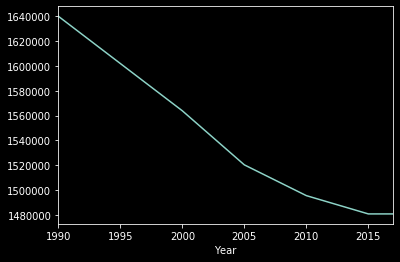

In [140]:
LAND_USE_FOREST_ITEMS = ['Forestry', 'Forest land', 'Primary Forest','Other naturally regenerated forest', 'Planted Forest']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) & land_use_all.Element.str.match('Area')]
forested_area_yearly = land_use.groupby(["Area", "Year"]).Value.sum()
forested_area_yearly.loc['Brazil'].plot()

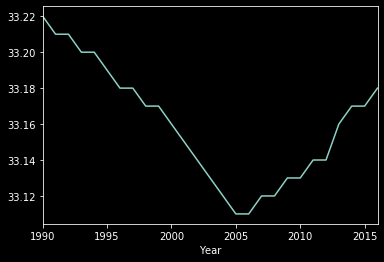

In [105]:
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly.loc['Norway'].plot()


In [106]:
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

In [116]:
env_land_cover = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas")].groupby(["Area", "Year"]).Value.sum()


In [158]:
# the results seem to differ between MODIS and CCI_L
env_land_cover_MODIS = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") & env_land_cover_all.Element.str.match("Area from MODIS")].groupby(["Area", "Year"]).Value.sum()

env_land_cover_CCI_LC = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") & env_land_cover_all.Element.str.match("Area from CCI_LC")].groupby(["Area", "Year"]).Value.sum()


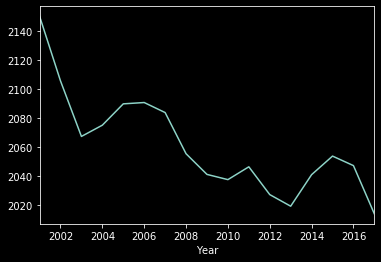

In [163]:
env_land_cover_MODIS.loc["Switzerland"].plot()

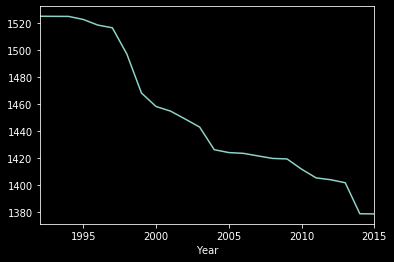

In [164]:
env_land_cover_CCI_LC.loc["Switzerland"].plot()

## The wood trade
Later we've started to look for the biggest producers and consumers of the wood in the world.

In [166]:
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')


## Is agricultural industry influencing deforestation? 
One of the most negative influences on the deforestation might have an agricultural industry. We've decided to investigate this possible connection.

In [ ]:
#TODO

## Is breeding farm animals influencing deforestation? 
Breeding animals might be space consumig, we've searched for the origin of the land used for this purpose.


In [ ]:
#TODO